# CONTROLLO CONTI OPAMP

***
***

## IMPORT MODULES

In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import seaborn as sns
import numpy as np
from scipy import stats
from scipy.optimize import curve_fit
from scipy.misc import derivative

## MISURE DIRETTE

In [9]:
Rf = 82462 #ohm
R1 = 8089.4 #ohm
R3 = 46.54 #ohm
C1 = 977 * 1e-12 #farad

FS_Rf = 100 #kohm
FS_R1 = 10 #kohm
FS_R3 = 1000 #ohm
FS_C1 = 1000 * 1e-12 #farad

SCALA_Rf = 0.0007
SCALA_R1 = 0.0007
SCALA_R3 = 0.001
SCALA_C1 = 0.025

DIGIT_R = 8
DIGIT_C = 15

RES_Rf = 1 #ohm
RES_R1 = 0.1 #ohm
RES_R3 = 0.01 #ohm
RES_C1 = 1e-12 #farad

In [10]:
def propagazione(R, FS, SCALA, DIGIT, RES):

    CONV = 0.58

    sigma = np.sqrt( (CONV * SCALA * R)**2 + (CONV * DIGIT * RES)**2 )

    return sigma

In [11]:
err_Rf = propagazione(Rf, FS_Rf, SCALA_Rf, DIGIT_R, RES_Rf)
err_R1 = propagazione(R1, FS_R1, SCALA_R1, DIGIT_R, RES_R1)
err_R3 = propagazione(R3, FS_R3, SCALA_R3, DIGIT_R, RES_R3)
err_C1 = propagazione(C1, FS_C1, SCALA_C1, DIGIT_C, RES_C1)

In [12]:
print(
    'Rf = ' + format(Rf * 1e-3, '.2f') + ' +/- ' + format(err_Rf * 1e-3, '.2f') + '   k\u03A9' + '\n' +
    'R1 = ' + format(R1 * 1e-3, '.3f') + ' +/- ' + format(err_R1 * 1e-3, '.3f') + '  k\u03A9' + '\n' +
    'R3 = ' + format(R3 , '.2f') + ' +/- ' + format(err_R3, '.2f') + '   \u03A9' + '\n' +
    'C1 = ' + format(C1 * 1e9, '.3f') + ' +/- ' + format(err_C1 * 1e9, '.3f') + '  nF'
)

Rf = 82.46 +/- 0.03   kΩ
R1 = 8.089 +/- 0.003  kΩ
R3 = 46.54 +/- 0.05   Ω
C1 = 0.977 +/- 0.017  nF


## STIMA TEORICA DEL GUADAGNO

In [13]:
G = Rf / R1

def GRf(x):
    return x / R1

def GR1(x):
    return Rf / x

der_GRf = derivative(GRf, Rf, dx = 1e-8)
der_GR1 = derivative(GR1, R1, dx = 1e-8)

err_G = ( (der_GRf * err_Rf)**2 + (der_GR1 * err_R1)**2 )**0.5

In [14]:
print(
    'G = ' + format(G, '.3f') + ' +/- ' + format(err_G, '.3f')
)

G = 10.194 +/- 0.006


## STIMA TEORICA DELLA FREQUENZA DI TAGLIO

In [9]:
ft = (2 * np.pi * R1 * C1)**-1

def ftR1(x):
    return (2 * np.pi * x * C1)**-1

def ftC1(x):
    return (2 * np.pi * R1 * x)**-1

der_ftR1 = derivative(ftR1, R1, dx = 1e-15)
der_ftC1 = derivative(ftC1, C1, dx = 1e-15)

err_ft = ( (der_ftR1 * err_R1)**2 + (der_ftC1 * err_C1)**2 )**0.5

In [10]:
print(
    'ft = ' + format(ft * 1e-3, '.1f') + ' +/- ' + format(err_ft * 1e-3, '.1f') + ' kHZ'
)

ft = 20.1 +/- 0.3 kHZ


# FIT LINEARIZZATO BODE

***
***

In [3]:
# CONSTANTS
sigmaL = 0.040
sigmaK = 0.015

In [4]:
def lin(x, a, b):  
    return a + b * x

In [30]:
file_name = '../Data/datadiff.txt'
data = pd.read_csv(file_name, index_col = False, header = None, sep = '\t')
data.index = np.arange(1, len(data)+1)
data.columns = ['freq (Hz)', 'Vin (V)', 'Vout (V)', 'Vin/div', 'Vout/div']

sim = pd.read_csv('../Data/Simulations/DIFF_OUT.txt', index_col = False, header = None, sep = '\t')
sim.columns = ['f', 'H']

# CALCOLO FUNZIONE DI TRASFERIMENTO ED ERRORE
data['T'] = data['Vout (V)'] / data['Vin (V)']
data['sigma T'] = data['T'] * np.sqrt( (sigmaL * data['Vin/div'] / data['Vin (V)'])**2 + (sigmaL * data['Vout/div'] / data['Vout (V)'])**2 + 2 * (sigmaK)**2)
data['sigma Tr'] = data['T'] * np.sqrt( (sigmaL * data['Vin/div'] / data['Vin (V)'])**2 + (sigmaL * data['Vout/div'] / data['Vout (V)'])**2)


# ARANCIONE
linear_data = data.iloc[5:10, :]

linear_data

,freq (Hz),Vin (V),Vout (V),Vin/div,Vout/div,T,sigma T,sigma Tr
6,18000,0.984,6.43,0.2,2.0,6.534553,0.169255,0.097120
7,19000,0.984,6.70,0.2,2.0,6.808943,0.174748,0.098358
8,20000,0.984,6.91,0.2,2.0,7.022358,0.179054,0.099345
9,21000,0.984,7.01,0.2,2.0,7.123984,0.181114,0.099822
10,22000,0.984,7.24,0.2,2.0,7.357724,0.185875,0.100936


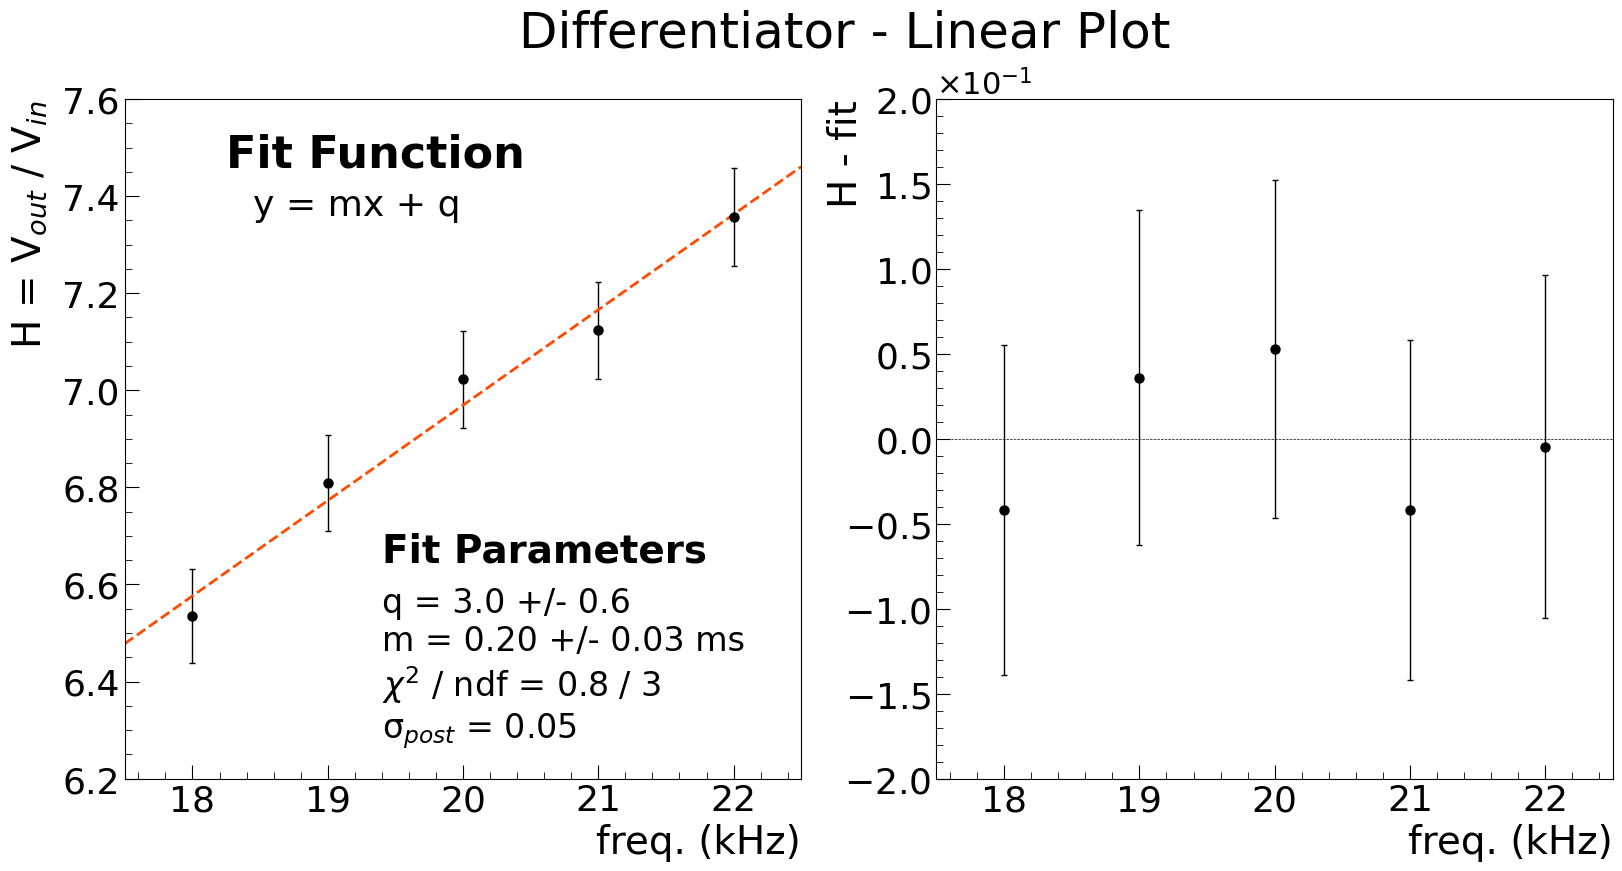

In [43]:
# FIG SETTINGS AND AXES
fig = plt.figure(figsize=(19.2, 9), dpi = 100)
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

# CONSTANTS
XMIN = 17.5
XMAX = 22.5
YMIN = 6.2
YMAX = 7.6
RESXMIN = XMIN
RESXMAX = XMAX
RESYMIN = -0.20
RESYMAX = 0.20

# PERFORM THE FIT
par, cov = curve_fit(f = lin, xdata = linear_data['freq (Hz)'] * 1e-3, ydata = linear_data['T'], sigma = linear_data['sigma Tr'], absolute_sigma = True)
func = lin(linear_data['freq (Hz)'], *par)

# GET FIT PARAMETERS AND PARAMETER ERRORS
error = []

for i in range(len(par)):
    try:
        error.append(np.absolute(cov[i][i])**0.5)
    except:
        error.append( 0.00 )

fit_par = par
fit_err = np.array(error)

a = fit_par[0]
b = fit_par[1]
err_a = fit_err[0]
err_b = fit_err[1]
cov_ab = cov[0][1]

# COMPUTE RESIDUALS
res = linear_data['T'] - lin(linear_data['freq (Hz)'] * 1e-3, *par)

# COMPUTE CHI2
chi2 = np.sum( ( res / linear_data['sigma Tr'] )**2 )

# COMPUTE SIGMA_POST
sigma_post = np.sqrt( np.sum( res**2 ) / (len(linear_data['freq (Hz)']) - 2) )

# PLOT FIT FUNCTION
ax1.plot(np.arange(XMIN, XMAX + 1, 1), lin(np.arange(XMIN, XMAX + 1, 1), *par), color = '#FF4B00', linewidth = 2, linestyle = 'dashed', label = 'y = a + bx')

# PLOT DATA
ax1.errorbar(linear_data['freq (Hz)'] * 1e-3, linear_data['T'], xerr = 0, yerr = linear_data['sigma Tr'], marker = '.', markersize = 13, elinewidth=1, color = '#000000', linewidth=0, capsize=2, label = 'Measures')

# PLOT RESIDUALS
ax2.errorbar(linear_data['freq (Hz)'] * 1e-3, res, xerr = 0, yerr = linear_data['sigma Tr'], marker = '.', markersize = 13, elinewidth=1, color = '#000000', linewidth=0, capsize=2, label = 'Residuals')

# DRAW DASHED 'ZERO' LINE
ax2.axhline(color = '#000000', linewidth = 0.5, linestyle = 'dashed')

aa = 'q = ' + format(a, '1.1f') + ' +/- ' + format(err_a, '1.1f') 
bb = 'm = ' + format(b, '1.2f') + ' +/- ' + format(err_b, '1.2f') + ' ms'
chisq = '$\chi^{2}$ / ndf = ' + format(chi2, '1.1f') + ' / ' + format(len(linear_data['freq (Hz)'] ) - len(par), '1.0f') 
sigmap = '\u03C3$_{post}$ = ' + format(sigma_post, '1.2f')

ax1.text(0.38, 0.32, 'Fit Parameters', fontsize = 28, fontweight = 'bold', transform=ax1.transAxes)

ax1.text(0.38, 0.06, aa + '\n' + bb + '\n' + chisq + '\n' + sigmap, fontsize = 24, color = '#000000', transform = ax1.transAxes)

ax1.text(0.15, 0.90, 'Fit Function', fontsize = 32, fontweight = 'bold', transform=ax1.transAxes)

ax1.text(0.19, 0.83, 'y = mx + q', fontsize = 26, color = '#000000', transform = ax1.transAxes)

# PLOT TITLE
fig.suptitle('Differentiator - Linear Plot', fontsize = 36)

# AXIS LABELS
ax1.set_xlabel('freq. (kHz)', fontsize = 28, loc = 'right')
ax1.set_ylabel('H = V$_{out}$ / V$_{in}$', fontsize = 28, loc = 'top', labelpad = 10)
ax2.set_xlabel('freq. (kHz)', fontsize = 28, loc = 'right')
ax2.set_ylabel('H - fit', fontsize = 28, loc = 'top', labelpad = -15)

# AXIS TICKS
ax1.tick_params(axis = 'x', which = 'major', labelsize = 26, direction = 'in', length = 10)
ax1.tick_params(axis = 'y', which = 'major', labelsize = 26, direction = 'in', length = 10)
ax1.tick_params(axis = 'both', which = 'minor', labelsize = 26, direction = 'in', length = 5)
ax1.set_xticks(ticks = ax1.get_xticks(), minor = True)
ax1.set_yticks(ticks = ax1.get_yticks(), minor = True)
ax1.minorticks_on()
#ax1.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
#ax1.xaxis.get_offset_text().set_fontsize(22)
#ax1.ticklabel_format(axis = 'x', style = 'scientific', scilimits = (0, 0))
ax2.tick_params(axis = 'both', which = 'major', labelsize = 26, direction = 'in', length = 10)
ax2.tick_params(axis = 'both', which = 'minor', labelsize = 26, direction = 'in', length = 5)
ax2.set_xticks(ticks = ax1.get_xticks(), minor = True)
ax2.set_yticks(ticks = ax1.get_yticks(), minor = True)
ax2.minorticks_on()
ax2.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax2.yaxis.get_offset_text().set_fontsize(22)
ax2.ticklabel_format(axis = 'y', style = 'scientific', scilimits = (0, 0))

# PLOT RANGE
ax1.set_xlim(left = XMIN, right = XMAX)
ax1.set_ylim(bottom = YMIN, top = YMAX)
ax2.set_xlim(left = RESXMIN, right = RESXMAX)
ax2.set_ylim(bottom = RESYMIN, top = RESYMAX)

fig.savefig('../Plots/Report_Plots/diff_lin_bode.png', dpi = 300, facecolor = 'white')

plt.show()

In [45]:
MAX = 9.75813325961185
ERR_MAX = 0.038944371818336494

In [46]:
ftt = ( ( MAX * 2**-0.5 ) - a ) / ( b * 1e-3 )

def fta(x):
    return ( ( MAX * 2**-0.5 ) - x ) / ( b * 1e-3 )

def ftb(x):
    return ( ( MAX * 2**-0.5 ) - a ) / ( x * 1e-3 )

der_fta = derivative(fta, a, dx = 1e-8)
der_ftb = derivative(ftb, b, dx = 1e-8)

err_ftt = np.sqrt( (der_fta * err_a)**2 + (der_ftb * err_b)**2 + 2 * ( MAX  * 0.015 / ( np.sqrt(2) * b * 1e-3 ) )**2 + 2 * der_fta * der_ftb * cov_ab )

print(
    'ft = ' + format(ftt * 1e-3, '.1f') + ' +/- ' + format(err_ftt * 1e-3, '.1f') + ' kHZ'
)

ft = 19.6 +/- 0.8 kHZ


In [47]:
l = np.abs(chi2 - (len(linear_data['freq (Hz)'] ) - len(par))) / np.sqrt(2 * (len(linear_data['freq (Hz)'] ) - len(par)))
l

0.9052580341930465

In [49]:
ftt

19647.17633072284

In [50]:
err_ftt

779.8258019708063